![Py4Eng](img/logo.png)

# Curve fitting
## Yoav Ram

In [1]:
import urllib.request
import os.path
import zipfile

%matplotlib inline
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_context('talk')

import scipy
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from scipy.stats import linregress

import statsmodels.api as sm

Our focus today will be on modeling population growth. 
We will start with human populations and use data from the [World Bank](http://www.worldbank.org/) on the [population size of countries](http://data.worldbank.org/indicator/SP.POP.TOTL) around the world from 1960 until 2018.

# Data preparation - World Bank

> In Data Science, 80% of time spent prepare data, 20% of time spent complain about need for prepare data.
    — [Big Data Borat](https://twitter.com/BigDataBorat/status/306596352991830016") (@BigDataBorat) February 27, 2013

So let's prepare the data from *scratch*.

Start by retrieving the data as a zip file (if not already downloaded). Follow the link to the World Bank page on [Population, total](http://data.worldbank.org/indicator/SP.POP.TOTL), click `DOWNLOAD DATA`, choose `CSV`, a zip file will be downloaded.  

Even better, click the `CSV` button with the right button and click `Copy link address` in the context menu. This link can be used to get the file directly from Python using `urllib`:

In [11]:
fname = r'../data/world_growth.zip'
url = 'http://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=csv'

if not os.path.exists(fname):
    urllib.request.urlretrieve(url, fname)
print(fname, 'exists:', os.path.exists(fname))

../data/world_growth.zip exists: True


Open the file using the zipfile module and read it using Pandas, skipping the first two rows and dropping the columns that have `NaN` values:

In [12]:
with zipfile.ZipFile(fname) as z:
    for f in z.filelist:
        print(f.filename)
        if f.filename.startswith('API_SP'):
            csv_fname = f.filename 

Metadata_Indicator_API_SP.POP.TOTL_DS2_en_csv_v2_511378.csv
API_SP.POP.TOTL_DS2_en_csv_v2_511378.csv
Metadata_Country_API_SP.POP.TOTL_DS2_en_csv_v2_511378.csv


In [16]:
with zipfile.ZipFile(fname) as z:
    f = z.open(csv_fname)
    df = pd.read_csv(f, skiprows=3)
df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,Unnamed: 64
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,102046.0,102560.0,103159.0,103774.0,104341.0,104872.0,105366.0,105845.0,NaN,NaN
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996973.0,9169410.0,9351441.0,9543205.0,9744781.0,9956320.0,...,30117413.0,31161376.0,32269589.0,33370794.0,34413603.0,35383128.0,36296400.0,37172386.0,NaN,NaN
2,Angola,AGO,"Population, total",SP.POP.TOTL,5454933.0,5531472.0,5608539.0,5679458.0,5735044.0,5770570.0,...,24220661.0,25107931.0,26015780.0,26941779.0,27884381.0,28842484.0,29816748.0,30809762.0,NaN,NaN
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0,2866376.0,NaN,NaN
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,83747.0,82427.0,80774.0,79213.0,78011.0,77297.0,77001.0,77006.0,NaN,NaN


In [17]:
df.drop(['2019', 'Unnamed: 64'], axis=1, inplace=True)
df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,101455.0,101669.0,102046.0,102560.0,103159.0,103774.0,104341.0,104872.0,105366.0,105845.0
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996973.0,9169410.0,9351441.0,9543205.0,9744781.0,9956320.0,...,28394813.0,29185507.0,30117413.0,31161376.0,32269589.0,33370794.0,34413603.0,35383128.0,36296400.0,37172386.0
2,Angola,AGO,"Population, total",SP.POP.TOTL,5454933.0,5531472.0,5608539.0,5679458.0,5735044.0,5770570.0,...,22514281.0,23356246.0,24220661.0,25107931.0,26015780.0,26941779.0,27884381.0,28842484.0,29816748.0,30809762.0
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0,2866376.0
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,84463.0,84449.0,83747.0,82427.0,80774.0,79213.0,78011.0,77297.0,77001.0,77006.0


In [18]:
print(df['Country Name'].values[:10])

['Aruba' 'Afghanistan' 'Angola' 'Albania' 'Andorra' 'Arab World'
 'United Arab Emirates' 'Argentina' 'Armenia' 'American Samoa']


We now want to **tidy our data** - transform the dataset to a **DataFrame** format:

> Tidy datasets are easy to manipulate, model and visualize, and have a specific structure: each variable is a column, each observation is a row, and each type of observational unit is a table - [Hadley Wickham (2014), _Tidy Data_, J. Stat. Soft.](http://www.jstatsoft.org/v59/i10)


This means that every row in the table has exactly one measurement - population size - with all the relevant variables - country name and year.
Read more on [tidy data](http://www.jstatsoft.org/v59/i10).

We do this using Pandas' `melt` function: 

In [19]:
print(df.shape)
df = pd.melt(
    df, 
    id_vars=('Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'), 
    var_name='Year', 
    value_name='Population'
)
print(df.shape)
df.head()

(264, 63)
(15576, 6)


,Country Name,Country Code,Indicator Name,Indicator Code,Year,Population
0,Aruba,ABW,"Population, total",SP.POP.TOTL,1960,54211.0
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,1960,8996973.0
2,Angola,AGO,"Population, total",SP.POP.TOTL,1960,5454933.0
3,Albania,ALB,"Population, total",SP.POP.TOTL,1960,1608800.0
4,Andorra,AND,"Population, total",SP.POP.TOTL,1960,13411.0


In [20]:
df.tail()

,Country Name,Country Code,Indicator Name,Indicator Code,Year,Population
15571,Kosovo,XKX,"Population, total",SP.POP.TOTL,2018,1845300.0
15572,"Yemen, Rep.",YEM,"Population, total",SP.POP.TOTL,2018,28498687.0
15573,South Africa,ZAF,"Population, total",SP.POP.TOTL,2018,57779622.0
15574,Zambia,ZMB,"Population, total",SP.POP.TOTL,2018,17351822.0
15575,Zimbabwe,ZWE,"Population, total",SP.POP.TOTL,2018,14439018.0


We get rid of rows that have `NA` values:

In [21]:
df.dropna(axis=0, inplace=True)
print(df.shape)
df.head()

(15409, 6)


,Country Name,Country Code,Indicator Name,Indicator Code,Year,Population
0,Aruba,ABW,"Population, total",SP.POP.TOTL,1960,54211.0
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,1960,8996973.0
2,Angola,AGO,"Population, total",SP.POP.TOTL,1960,5454933.0
3,Albania,ALB,"Population, total",SP.POP.TOTL,1960,1608800.0
4,Andorra,AND,"Population, total",SP.POP.TOTL,1960,13411.0


Note that the `Year` column has a type `O` (object) instead of `int`, so we change that:

In [22]:
print('Year', df['Year'].dtype, 'Population', df['Population'].dtype)
df['Year'] = df['Year'].astype(int)
print('Year', df['Year'].dtype, 'Population', df['Population'].dtype)

Year object Population float64
Year int64 Population float64


# Data exploration with plots

To get an idea of how the data looks like, let's start with Israel and two other small developed countries.
We will plot their population size over time:

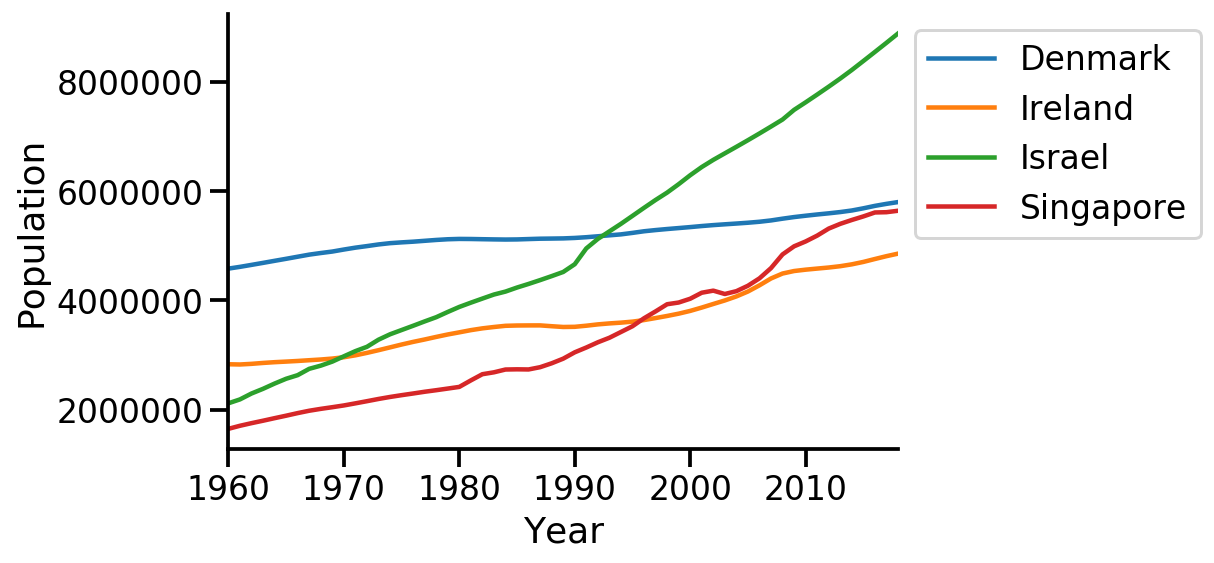

In [23]:
largest_countries = 'Israel', 'Denmark', 'Singapore', 'Ireland'
largest_mask = df['Country Name'].isin(largest_countries)
largest = df[largest_mask]

fig, ax = plt.subplots()
largest.groupby('Country Name', sort=True).plot('Year', 'Population', ax=ax)
plt.legend(sorted(largest_countries), bbox_to_anchor=(1, 1))
plt.ylabel('Population')
sns.despine()

# Exponential growth model

How do we model the growth of a population?

According to [Malthus](http://en.wikipedia.org/wiki/Thomas_Robert_Malthus), if the instantaneous rate of births is $b$ and the instantaneous rate of deaths is $r$, then the instantaneous rate of growth (or decline) of the population is

$$
\frac{dN(t)}{dt} = b N(t) - d N(t) = r N(t)
$$

where $N(t)$ is the population size at time $t$ and $r=b-d$ is the specific growth rate (or per capita growth rate).

This is called the Malthusian growth model or more commonly the [exponential growth model](https://en.wikipedia.org/wiki/Exponential_growth).

This ODE can be solved via [logarithmic differentiation](https://en.wikipedia.org/wiki/Logarithmic_differentiation):

$$
\frac{dN(t)}{dt} = r N(t) \Rightarrow \\
\frac{1}{N(t)} \frac{dN(t)}{dt} = r \Rightarrow \\
\frac{d \log{N(t)}}{dt} = r \Rightarrow \\
\log{N(t)} =  r t + C \Rightarrow \\
N(t) = e^{rt + C} = e^{rt} e^{C}
$$

Now add the boundary condition $N(0) = N_0$ to get

$$
e^{C} = N_0
$$

and finally

$$
N(t) = N(0) e^{rt}
$$

Note that during the integration we found that the **logarithm of the population should be a linear function of time** $\log{N(t)} = \log{N(0)} + rt$.

Let's check if the world population growth fits the exponential model. 
First define a new column for the log of the population size:

In [24]:
df['LogPopulation'] = np.log10(df['Population'])

![G7 map](https://upload.wikimedia.org/wikipedia/commons/thumb/4/45/Group_of_Seven_%28G7%29_Countries.svg/320px-Group_of_Seven_%28G7%29_Countries.svg.png)

Let's concentrate on the [G7 countires](http://en.wikipedia.org/wiki/Group_of_Seven).

In [25]:
G7_countries = ('Canada', 'France', 'Germany', 'Italy', 'Japan', 'United Kingdom', 'United States')
G7_mask = df['Country Name'].isin(G7_countries)
G7 = df[G7_mask]
G7.head()

,Country Name,Country Code,Indicator Name,Indicator Code,Year,Population,LogPopulation
33,Canada,CAN,"Population, total",SP.POP.TOTL,1960,17909009.0,7.253072
53,Germany,DEU,"Population, total",SP.POP.TOTL,1960,72814900.0,7.862220
75,France,FRA,"Population, total",SP.POP.TOTL,1960,46621669.0,7.668588
79,United Kingdom,GBR,"Population, total",SP.POP.TOTL,1960,52400000.0,7.719331
114,Italy,ITA,"Population, total",SP.POP.TOTL,1960,50199700.0,7.700701


Now sort the countries based on the largest population in 2017 so that the next plot will have a legend that is ordered by country size. 

We start by splitting the data frame according to country name and extracting the max population size for each country so that we will have a column of the country name as index and the max population size as the value.
We then sort by the value (the population max size) and extract the index (the country).
We will use this sorted list for ordering the colors in the next plot.

In [26]:
G7_countries = G7.groupby('Country Name')['Population'].max() # split-apply-combine
G7_countries

Country Name
Canada             37058856.0
France             66987244.0
Germany            82927922.0
Italy              60789140.0
Japan             128070000.0
United Kingdom     66488991.0
United States     327167434.0
Name: Population, dtype: float64

In [27]:
G7_countries.sort_values(ascending=False, inplace=True)
G7_countries = G7_countries.index
print(G7_countries.tolist())

['United States', 'Japan', 'Germany', 'France', 'United Kingdom', 'Italy', 'Canada']


We now plot the log of the population sizes. 

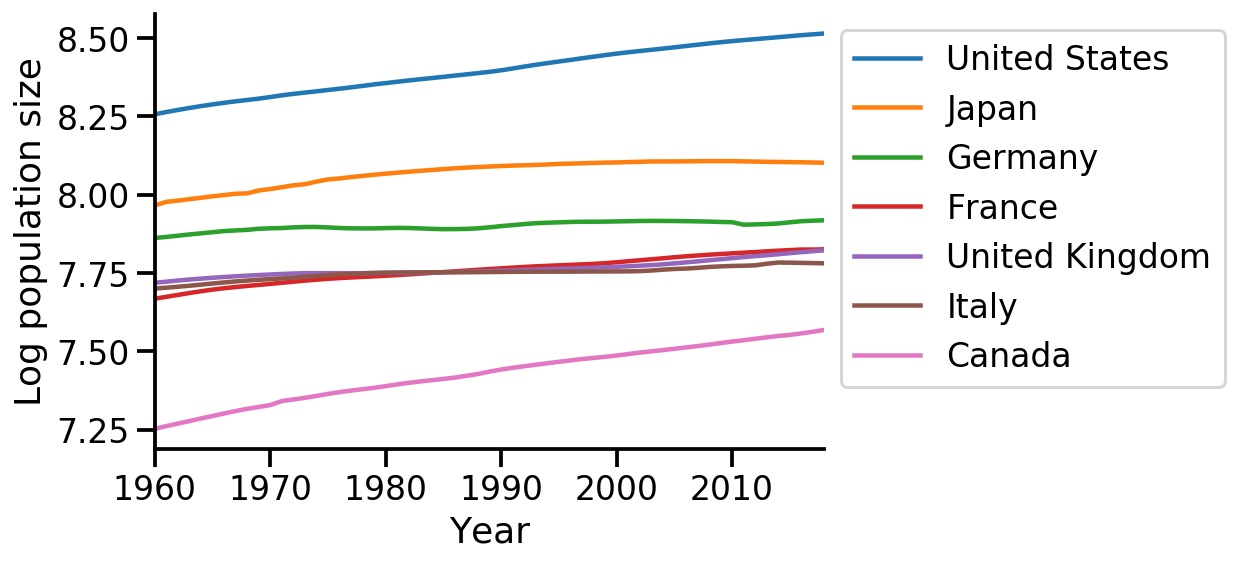

In [28]:
fig, ax = plt.subplots()
grp = G7.groupby('Country Name', sort=False)
for country in G7_countries:
    grp.get_group(country).plot('Year', 'LogPopulation', label=country, ax=ax)
ax.legend(bbox_to_anchor=(1, 1)) # bbox_to_anchor moves the legend 
ax.set_ylabel('Log population size')
sns.despine()

The lines look linear, lets plot the data with a linear regression - linear model fit.
We can quickly plot the linear models fit using seaborn's `lmplot` function.

Think: We assume the the log of the population size is a linear function of the year and that the residuals - the difference between the model prediction and the observed values - are normally distributed. 
Both assumptions are problematic - what would you do differently?



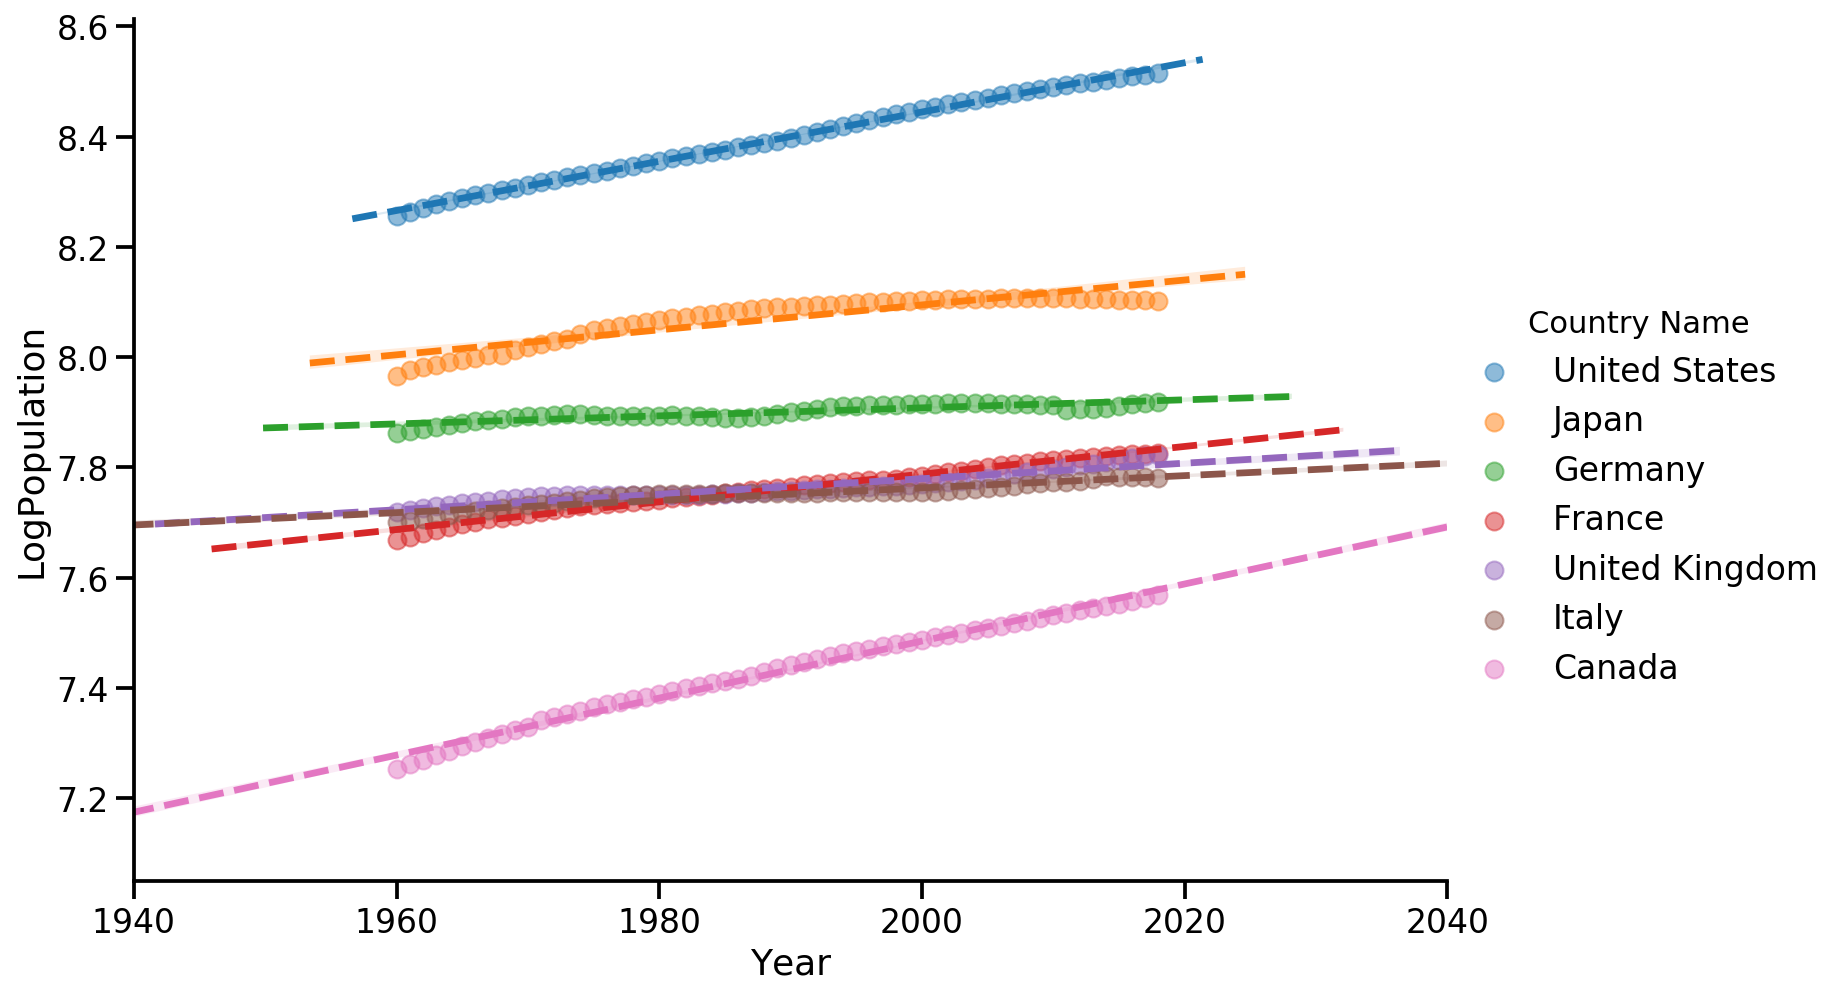

In [29]:
sns.lmplot(
    x='Year', 
    y='LogPopulation', 
    hue='Country Name', 
#     col='Country Name', 
#     col_wrap=3,
    data=G7, 
    height=7, 
    aspect=1.5, 
    line_kws=dict(ls='--'),
    scatter_kws=dict(alpha=0.5),
    hue_order=G7_countries
)
plt.xlim(1940, 2040);

This is interesting. While some countries fit the Malthusian model very well (United States, France, United Kingdom), some countries don't fit as well: Japan seems to have stopped growing during the 1980s, and, Germany, Italy and Canada also seem to decelerate their growth. 
For an interesting evolutionary perspective see [this paper](http::/doi.org/10.1016/j.tpb.2003.07.003):
> Ihara Y, Feldman MW (2004) Cultural niche construction and the evolution of small family size. Theor Popul Biol 65(1):105–111.

# Predictions using the exponential model

Let's use Scikit-learn's `LinearRegression` estimator to **extrapolate**: predict what will be the population of these countries if the rate at which they grow remain constant under the Malthusian model. 

Scikit-learn is especially convinient for prediction, but not so much for getting statistics like loglikelihood and p-values.

Remember that the linear model is $\log{N(t)} = r t + \log{N_0}$, where $r$ is the slope or the population growth rate and $N_0$ is the interception or the size of the population in year 0.
But then we have to exponentiate both sides of the equation as we want actual population size and not log population - so we get $N(t) = N_0 10^{rt}$.

In [30]:
from sklearn import linear_model

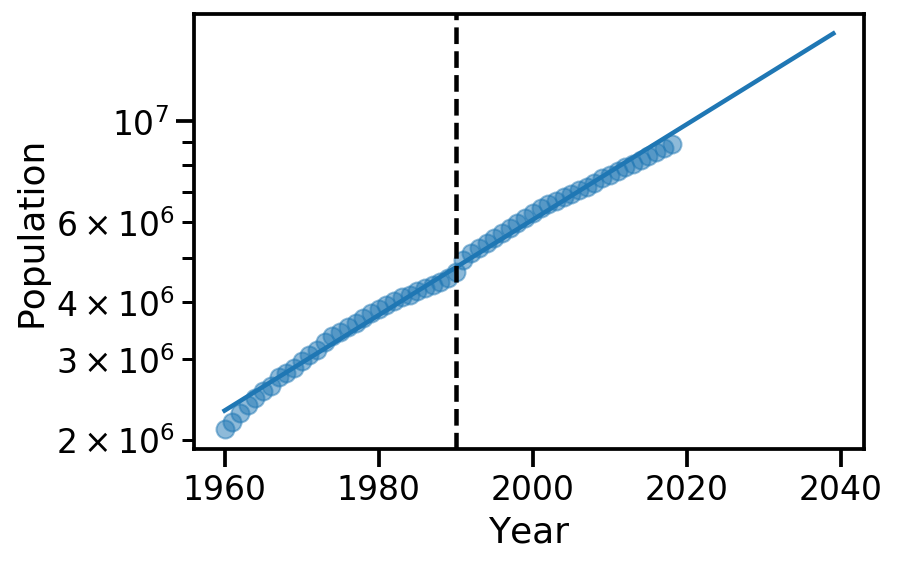

In [31]:
def extrapolate_plot(df, country_name, max_year=2040):
    country_df = df[df['Country Name'] == country_name]
    x = country_df['Year'].values
    y = country_df['Population'].values
    logy = country_df['LogPopulation'].values
    handles = plt.plot(x, y, 'o', alpha=0.5)

    years = np.arange(x.min(), max_year)
    lm = linear_model.LinearRegression()
    lm.fit(x.reshape((-1, 1)), logy)
    logpopulation = lm.predict(years.reshape(-1, 1))
    plt.plot(years, 10**logpopulation, label=country_name, color=handles[0].get_color())
    plt.xlabel('Year')
    plt.ylabel('Population')
    plt.yscale('log')

extrapolate_plot(df, "Israel")
plt.axvline(1990, color='k', ls='--');

How do you explain the jump around 1990?

Now we'll extrapolate for the four most populated countries in the world.

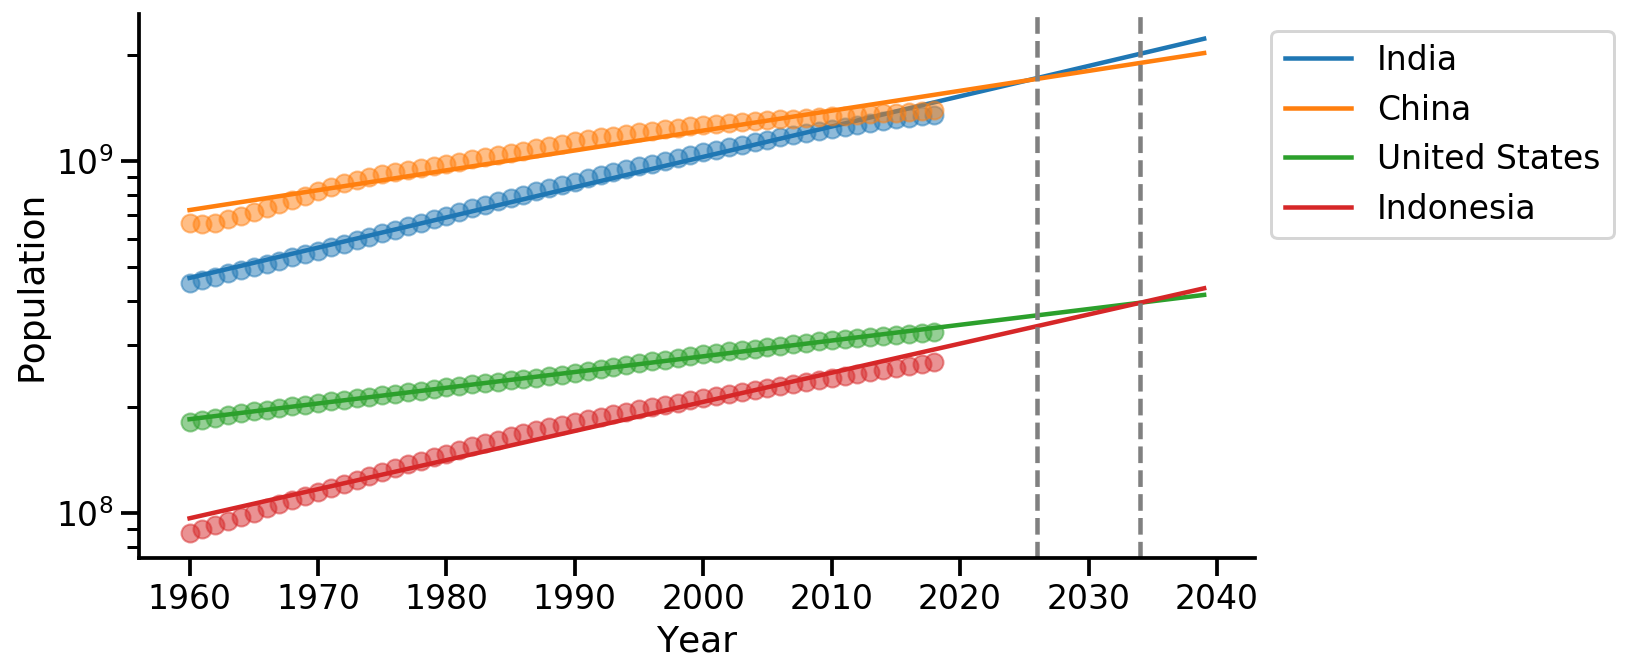

In [32]:
largest_countries = ('India', 'China', 'United States', 'Indonesia')
#                      'Nigeria', 'Russian Federation', 'Brazil', 'Bangladesh', 'Indonesia')

plt.figure(figsize=(10, 5))

for country_name in largest_countries:
    extrapolate_plot(df, country_name, max_year=2040)
# plt.ylim(5e7, 1e10)
plt.legend(bbox_to_anchor=(1, 1))

plt.axvline(x=2026, color='gray',  linestyle='--')
plt.axvline(x=2034, color='gray', linestyle='--')
sns.despine()

From our prediction, India will pass China around 2026 and Indonesia will pass United States around 2034. 

# Logistic growth model

The Malthusian/exponential growth model can't always be correct: many times growth decelerates and effectively stops when reaching a certain size $K$ (carrying capacity, maximum yield, maximum population density etc.). 
This is true for fish body size (Schnute 1981), microbial population size in a constant volume (Zwietering 1990), and natural animal populations. 
In these cases it is common to use the [**logistic growth model**](http://en.wikipedia.org/wiki/Logistic_function#In_ecology:_modeling_population_growth) in which the size of the population inhibits growth, leading to a maximum population size after which growth stops.

For example, consider a population $N(t)$ which consumes a resource $R(t)$ to grow.

$$
\frac{dR}{dt} = -h R N \\
\frac{dN}{dt} = \epsilon h R N \\
$$

Set $K = \epsilon R + N$ so that:
- $\frac{dK}{dt} = \epsilon \frac{dR}{dt} + \frac{dN}{dt} = 0$ and therefore $K$ is constant and we can set $K=\epsilon R(0)+N(0)$.
- $\epsilon R = K - N$.

Therefore we have

$$
\frac{dN}{dt} = \epsilon h R N  = \\ 
\epsilon h N (K-N) = \\ 
r N (1-\frac{N}{K})
$$
where $r = h / K$.

This is called the logistic ODE.

We can solve this equation by a similar approach to the exponential model:

$$
N(t) = \frac{K}{1 - \Big( 1 - \frac{K}{N(0)} \Big) e^{-r t} }
$$

In [33]:
def logistic(t, N0, K, r):
    return K / (1 - (1 - K/N0) * np.exp(-r * t))

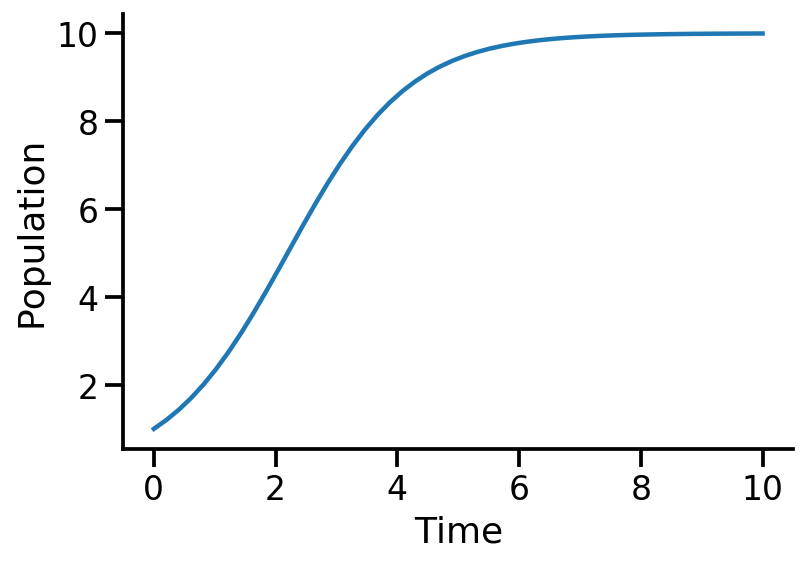

In [34]:
t = np.linspace(0,10)
N = logistic(t, N0=1, K=10, r=1)
plt.plot(t, N)
plt.xlabel('Time')
plt.ylabel('Population')
sns.despine();

## Fitting a logistic model 

So we have a standard growth model, but how do we find the right model (_i.e._ parameters: `N0`, `r`, `K`) for our data? To do this we need to **fit the logistic model** to our data. 
But this model is not linear and cannot be linearized like the exponential model; we need to perform non-linear fitting.

We will use a SciPy function called `curve_fit` that accepts a model (a function of `t` and some other arguments/parameters that returns `N`), data (`t` and `N`), initial guesses of the model parameters, and some other optional arguments.
It evaluates the model with the initial guesses and calculates the _fit_ of the result by _minimizing the sum of the squares of the residuals_ between the model and the data.
It then makes another guess of the model parameters, evaluates the model result and calculates the residuals, and again and again.
This operation isn't perfect, and when there are even just 3 or 4 model parameters there might be more than one minimum or the function might not find a minimum in a reasonable time.

## Simulated data

Before we try to work with real data we want to try it with simulated data and see that we know what we are doing. 
To simulate data we generate data from the logistic function and add some normally distributed noise:

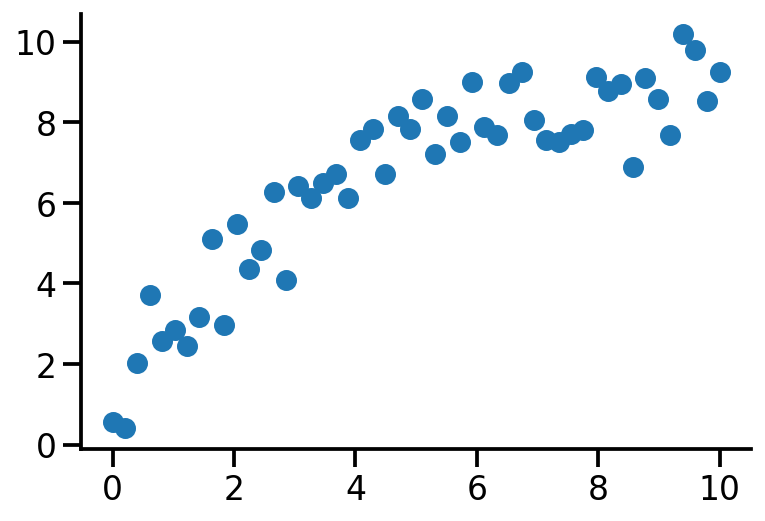

In [35]:
simulated = logistic(t, N0=1.5, K=8.5, r=0.75) +  np.random.normal(loc=0, scale=0.7, size=t.shape)
plt.scatter(t, simulated)
sns.despine()

Now we can call `curve_fit` and give it the simulated data and get back an estimate of the model parameters. As you can see, although there is a lot of noise, we get a pretty good estimate of the parameters.

N0=1.524, K=8.608, r=0.761


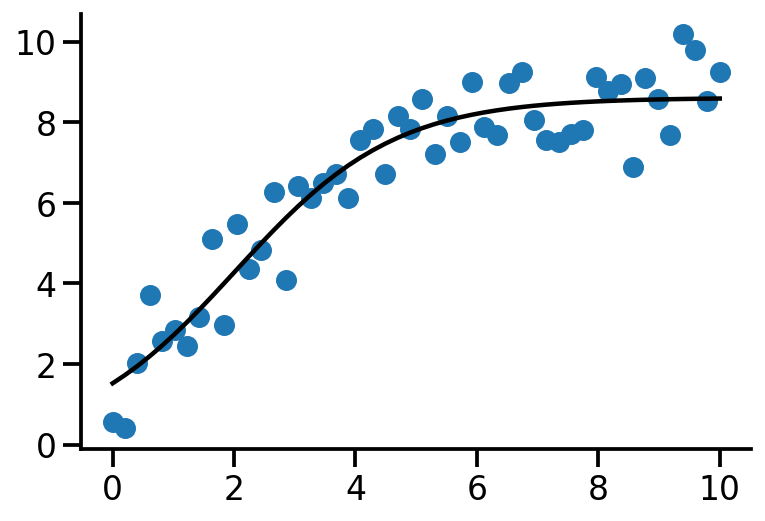

In [36]:
params, cov = curve_fit(f=logistic, xdata=t, ydata=simulated, p0=(1, 10, 1))
N0, K, r = params
plt.scatter(t, simulated)
plt.plot(t, logistic(t, N0, K, r), '-k')
sns.despine()
print('N0={0:.3f}, K={1:.3f}, r={2:.3f}'.format(N0, K, r))

We can also get confidence intervals for the parameter values from the `cov` return value. But if you need to work with confidence interals you might prefer to work with the package [lmfit](http://lmfit.github.io/lmfit-py/) which is easier to use if you need more than the basics.

## Real data: bacterial growth curves

We will use growth curves of _E. coli_ bacteria. [This data](https://github.com/Py4Life/TAU2015/blob/master/Yoav_311214c_only_OD.csv) was generated by growing bacteria in a 96-well microtiter plate.

![96-well plate](http://www.ddw-online.com/library/sid32/microplates.jpg)

In [38]:
fname = r'../data/Yoav_311214c_only_OD.csv'
df = pd.read_csv(fname)
df.head()

,Cycle Nr.,Time [s],Temp. [°C],A1,A2,A3,A4,A5,A6,A7,...,H4,H5,H6,H7,H8,H9,H10,H11,H12,Time
0,1,0.0,37.2,0.1128,0.1118,0.1186,0.1213,0.1131,0.1111,0.1178,...,0.1240,0.1352,0.1266,0.1147,0.1157,0.1084,0.1177,0.1217,0.1110,0.000000
1,2,1136.9,37.4,0.1164,0.1151,0.1189,0.1209,0.1173,0.1144,0.1221,...,0.1229,0.1386,0.1289,0.1154,0.1211,0.1103,0.1216,0.1208,0.1130,0.315806
2,3,2273.7,37.3,0.1221,0.1260,0.1242,0.1251,0.1247,0.1222,0.1312,...,0.1350,0.1431,0.1373,0.1219,0.1258,0.1175,0.1276,0.1408,0.1080,0.631583
3,4,3410.5,37.3,0.1315,0.1405,0.1335,0.1338,0.1342,0.1321,0.1469,...,0.1586,0.1493,0.1455,0.1362,0.1349,0.1263,0.1374,0.1777,0.1104,0.947361
4,5,4547.4,36.9,0.1451,0.1464,0.1467,0.1470,0.1486,0.1465,0.1584,...,0.1500,0.1622,0.1593,0.1481,0.1477,0.1385,0.1554,0.1537,0.1089,1.263167


We don't need the `Time [s]` column (we got `Time` in hours) and we don't need `Temp. [°C]`, so we drop these columns.

Then we melt the data.
That means that we transform our data from a matrix format (one row per timepoint, one column per well + columns for other variables such as time) into a data frame format (one row for each measurement, with one column for each measurement variable). 

In [39]:
df = df.drop(axis=1, labels=['Time [s]', 'Temp. [°C]'])
df = pd.melt(df, id_vars=('Time','Cycle Nr.'), var_name='Well', value_name='OD')
df.head()

,Time,Cycle Nr.,Well,OD
0,0.000000,1,A1,0.1128
1,0.315806,2,A1,0.1164
2,0.631583,3,A1,0.1221
3,0.947361,4,A1,0.1315
4,1.263167,5,A1,0.1451


Now let's add a column for the plate row (A - H) and the plate columns (1 - 12). We will use a list comprehension for that:

In [40]:
df['Row'] = [well[0] for well in df['Well']]
df['Col'] = [int(well[1:]) for well in df['Well']]
df.head()

,Time,Cycle Nr.,Well,OD,Row,Col
0,0.000000,1,A1,0.1128,A,1
1,0.315806,2,A1,0.1164,A,1
2,0.631583,3,A1,0.1221,A,1
3,0.947361,4,A1,0.1315,A,1
4,1.263167,5,A1,0.1451,A,1


Finally the data is **prepared** and we are ready to explore it.
Let's start by plotting the OD over time curve of every well - just to make sure we know what we have in our hands.

We can `seaborn.FacetGrid` to make faceted plots, but in this case I found that a straightforward matplotlib approach produces a better result.

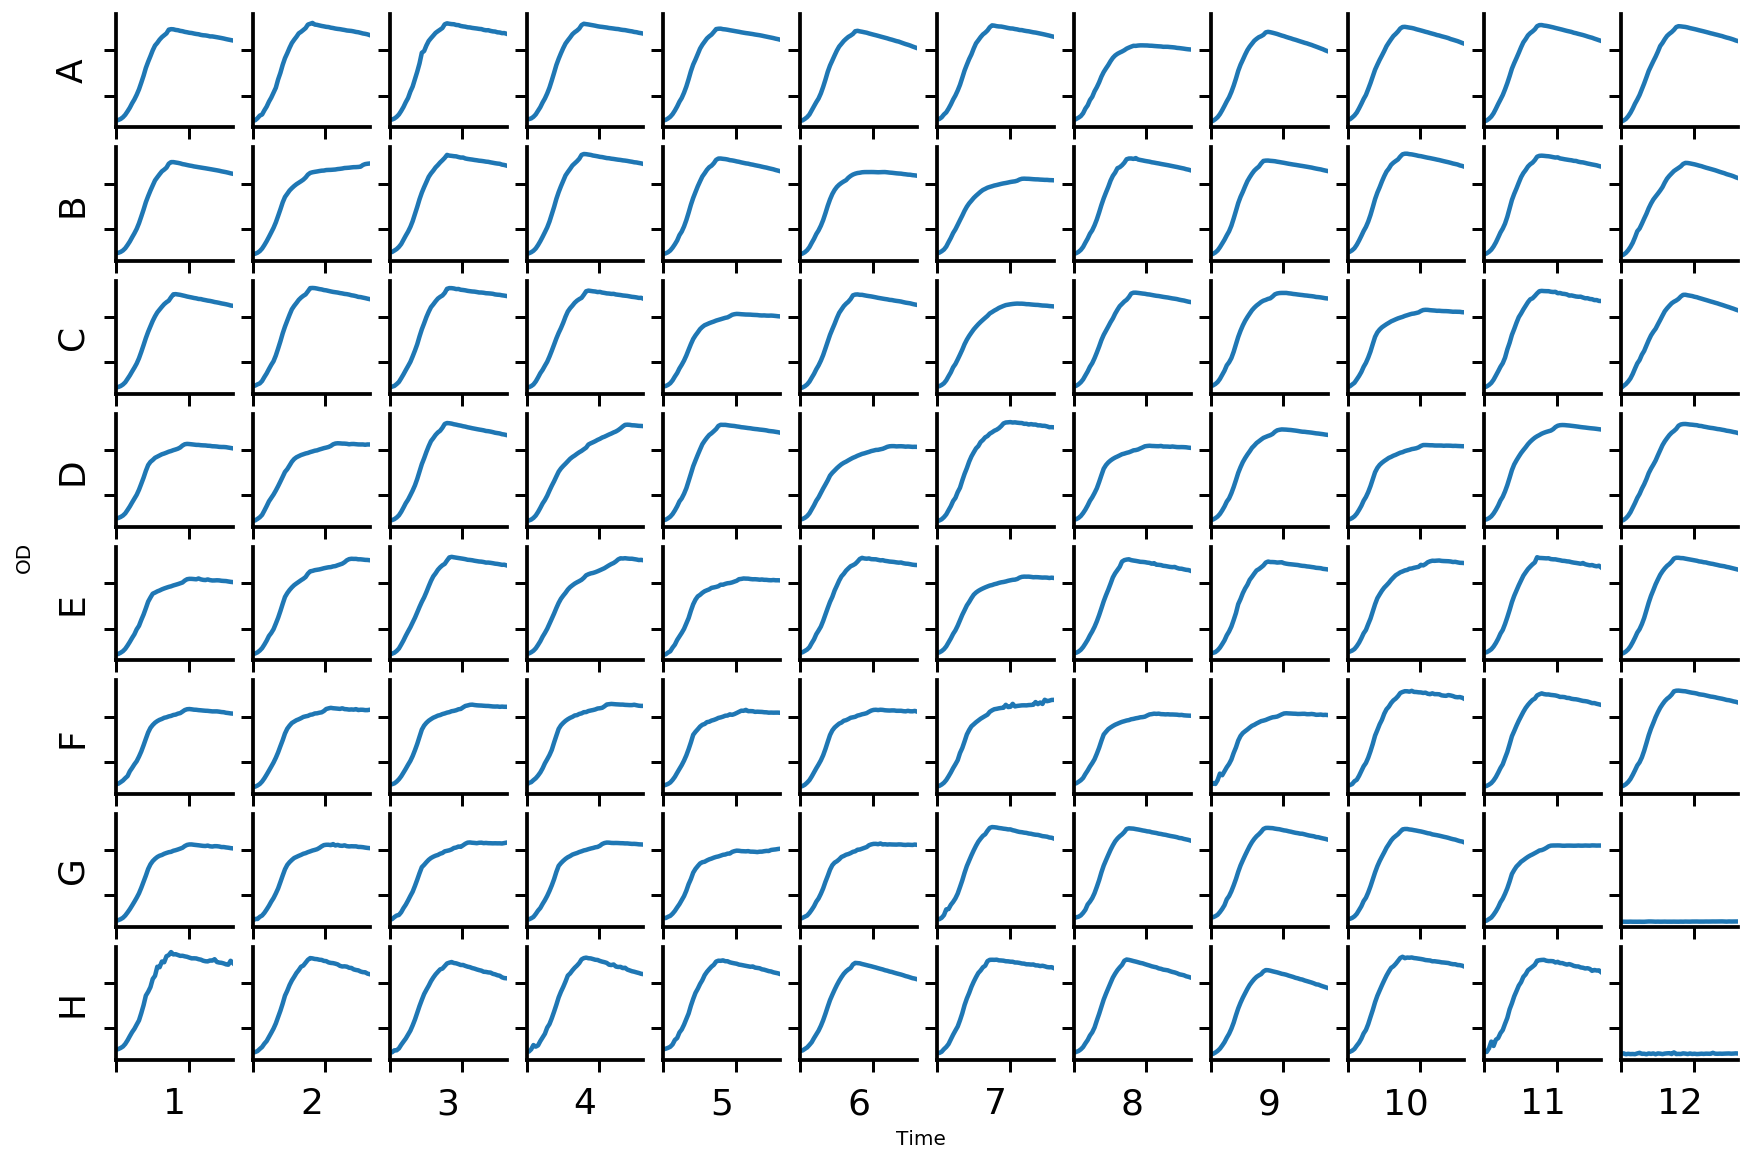

In [41]:
rows = df['Row'].unique()
cols = df['Col'].unique()

fig, axes = plt.subplots(len(rows), len(cols), sharex=True, sharey=True, figsize=(12, 8))
for i, row in enumerate(rows):
    for j, col in enumerate(cols):
        ax = axes[i, j]
        ax.set(xticks=[], yticks=[], xlabel='', ylabel='')
        _df = df[(df['Row'] == row) & (df['Col'] == col)]
        _df.plot('Time', 'OD', legend=False, ax=ax)
        if i == len(rows)-1:
            axes[i, j].set_xlabel(col)
    axes[i, 0].set_ylabel(row)

fig.text(0.5, 0, 'Time') # xlabel
fig.text(-0.01, 0.5, 'OD', rotation='vertical') # ylabel
sns.despine()
fig.tight_layout(h_pad=0.1, w_pad=0.1) # h_pad and w_pad control the padding between axes

In [241]:
# g = sns.FacetGrid(
#     data=df, 
#     col='Col', 
#     row='Row', 
#     sharex=True, 
#     sharey=True, 
#     height=0.75,
#     aspect=12/8, 
#     despine=True, 
#     margin_titles=True
# )
# g.map(plt.plot, 'Time', 'OD')
# g.set_titles(row_template='{row_name}', col_template='{col_name}')
# g.set_axis_labels('', '') # remove facets axis labels
# g.fig.text(0.5, 0, 'Time') # xlabel
# g.fig.text(-0.01, 0.5, 'OD', rotation='vertical') # ylabel
# for ax in g.axes.flat:
#     ax.set(xticks=[], yticks=[])

You might notice that the curves in G12 and H12 are constant - these are the blank/control wells. Let's get rid of them:

In [42]:
df = df[~df['Well'].isin(['G12', 'H12'])]

In order to fit a logistic curve to the data we need to calculate the average curve. This is easy (once you learn how to do it) in _pandas_. The idea is: we _split_ the data by one or more columns. Rows with the same values in these columns will be _grouped_ together. We then _apply_ an aggregation to these groups, meaning we make a single row out of each group. We then _combine_ the rows back together into a single data frame.

This strategy is known as _split-apply-combine_ and it is a very powerful strategy to work with data frames. One of it's powers is that it easily extends to parallel computing because the _apply_ part can be done in parallel over the different groups.

Using Pandas we will split using the `groupby` method; we will aggregate using `mean` (for general aggregations use `aggregate`); we will then resetthe indices (which were lost during the aggregation) with `reset_index`.

We want the mean OD value for each time point so we group by `Time` and aggregate with `mean`.

In [43]:
grouped = df.groupby('Time')
aggregated = grouped['OD'].mean().reset_index()
aggregated.head()

,Time,OD
0,0.000000,0.115427
1,0.315806,0.119079
2,0.631583,0.125883
3,0.947361,0.136205
4,1.263167,0.150218


Let's plot:

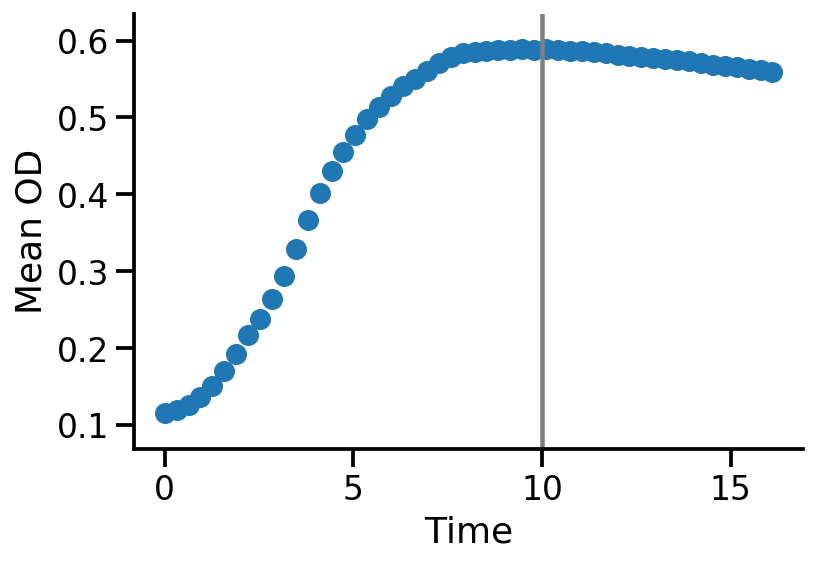

In [44]:
t = aggregated['Time']
N = aggregated['OD']

plt.scatter(t, N)
plt.xlabel('Time')
plt.ylabel('Mean OD')
plt.axvline(x=10, color='gray')
sns.despine()

You might notice that after about 11 hours the population size starts to decrease. This is an artifact of the experiments, due to the wells starting to dry out. Let's drop this data:

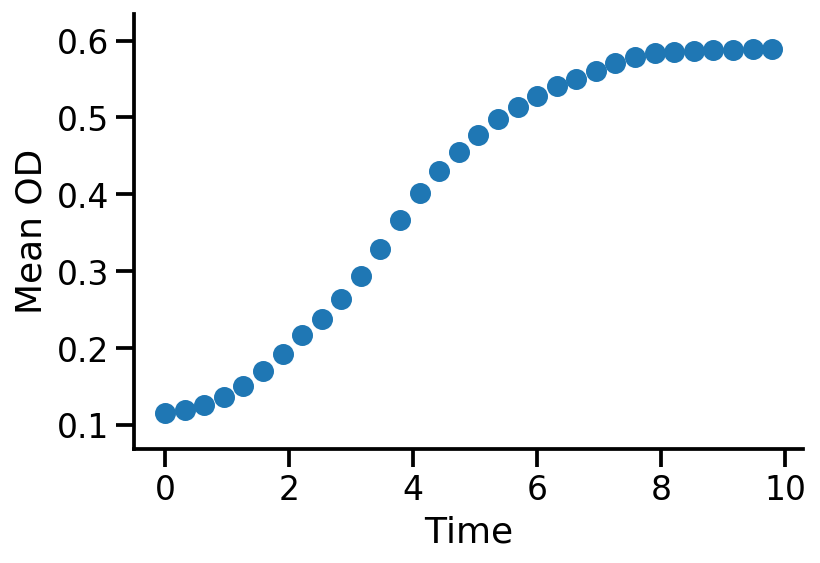

In [45]:
N = N[t<10]
t = t[t<10]

plt.scatter(t, N)
plt.xlabel('Time')
plt.ylabel('Mean OD')
sns.despine()

Now, finally, to the fitting (80% is data preparation!):

N0=0.081, K=0.611, r=0.605
MSE=0.00013


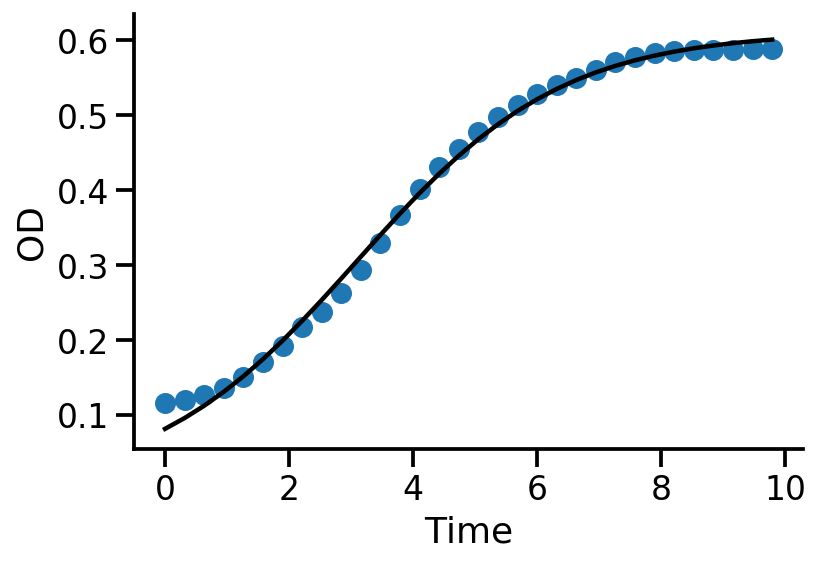

In [46]:
popt, cov = curve_fit(logistic, t, N, (N.min(), N.max(), 1))
N0, K, r = popt
Nhat = logistic(t, N0, K, r)
print('N0={:.3f}, K={:.3f}, r={:.3f}'.format(N0, K, r))
print("MSE={:.2g}".format(((N - Nhat)**2).mean()))

plt.scatter(t, N)
plt.plot(t, Nhat, '-k')
plt.xlabel('Time')
plt.ylabel('OD')
sns.despine();

The fit is... ok, but not that good for the begining or the end.
The results have a clear interpretation:
- the inferred initial density is ~0.08
- the inferred maximum density is ~0.61
- the inferred specific growth rate is ~0.6, which means that the bacteria divide approx every 36 minutes, which is in the acceptable range (see [Table 2](http://textbookofbacteriology.net/growth_3.html)).

## Exercise: Generalized logistic model

The [generalized logistic model](https://en.wikipedia.org/wiki/Generalised_logistic_function) has an additional parameter $\nu$ so that the curve doesn't have to be symmetric, that is, the time to get to $K/2$ can be longer/shorter than the time to get from $K/2$ to $K$.

$$
\frac{\partial N}{\partial t}= r N \bigg(1 - \bigg(\frac{N}{K}\bigg)^{\nu}\bigg)
$$

The other parameters are the same as the logistic model.

1. Fit the logistic and the generalized logistic model to the data.
1. Print the MSE of the two model fits.
1. Plot the fitted curves with the data.
1. Which is a better fit? The logistic model or the generalized logistic?

See [solution code](../solutions/curve-fitting.py).

Logistic:
	N0=0.081, K=0.611, r=0.605
	RSS: 0.004090
Generalized logistic:
	N0=0.005, K=0.590, r=0.374, ν=2.636
	RSS: 0.000033


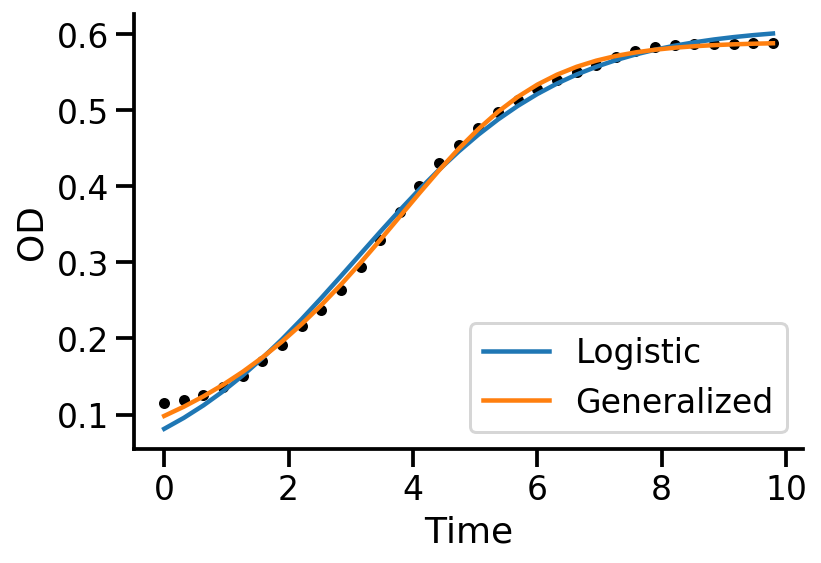

In [49]:


# the following line runs the solution code in the notebook
%run -i ../solutions/curve-fitting.py

These models are nested: the logistic model is just the generalized model with $\nu=1$. 
Therefore, we can use the [likelihood ratio test](https://en.wikipedia.org/wiki/F-test#Regression_problems) as an hypothesis test between them.

We check if the evidence (data) supports rejecting the null model (logisitc) in favor of the alternative model (generalized logistic) despite the additional parameters ($\nu$) of the alternative model.

In [50]:
n = t.size # number of samples
p0 = 3 # number of parameters in null model
p1 = 4 # number of parameters in alternative model
F = ((rss0 - rss1) / (p1 - p0)) / (rss1 / (n - p1)) # F-statistic, see https://en.wikipedia.org/wiki/F-test#Regression_problems
pvalue = scipy.stats.f(p1 -p0, n - p1).sf(F) # sf = 1-cdf
print("F-statistic: {:.2g}".format(F))
print("Likelihood-ratio test P-value = {:.2g}".format(pvalue))

F-statistic: 3.4e+03
Likelihood-ratio test P-value = 8.2e-31


A P-value of ~1e-31 is very low and so we can confidently reject logistic model in favor of the generalized logistic model.

# References

- [How to solve the exponential ODE](https://www.youtube.com/watch?v=mhO9eL9Nuz0)
- [Blog post](https://paulromer.net/economic-growth/) by Paul Romer on population and GDP growth
- [Blog post](https://www.yoavram.com/blog/growth-models/) by Yoav Ram on how to derive the logistic and generalized logistic models.

# Colophon
This notebook was written by [Yoav Ram](http://www.yoavram.com).

The notebook was written using [Python](http://python.org/) 3.7.
Dependencies listed in [environment.yml](../environment.yml).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)